### Imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from typing import Iterable, Union
from toggle import hide_toggle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from get_data import get_training, get_test
from learning import fit, evaluate, plot_history
from plots import plot_features, plot_compare_features


from numpy.random import seed
seed(9849)
from tensorflow import set_random_seed
set_random_seed(6432)

hide_toggle()

In [2]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel1:Iterable, kernel2:Iterable, conv_filt: int, dense_filt: int,
                 optimizer = 'adam', loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(conv_filt, kernel_size = kernel1,input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel2))
    model.add(Dropout(0.5))
    model.add(Dense(dense_filt, activation='relu')) #kolejne relu
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    return model

# Loading data

In [3]:
# dire = "./npy_data/"
dire = "./npy_data2/"
# dire = "./npy_data3/"

class_no8 = np.load(dire+'class_no8.npy')
data_no8 = np.load(dire+'data_no8.npy')


class_no13 = np.load(dire+'class_no13.npy')
data_no13 = np.load(dire+'data_no13.npy')

class_no18 = np.load(dire+'class_no18.npy')
data_no18 = np.load(dire+'data_no18.npy')

class_no23 = np.load(dire+'class_no23.npy')
data_no23 = np.load(dire+'data_no23.npy')

class_no28 = np.load(dire+'class_no28.npy')
data_no28 = np.load(dire+'data_no28.npy')

class_no33 = np.load(dire+'class_no33.npy')
data_no33 = np.load(dire+'data_no33.npy')

hide_toggle()

## Picture options - time x freq bands or time x channels

In [4]:
freq_bands = 'ijkl->jlik' #better
channels = 'ijkl->jlki'
option = freq_bands

## Prepared combinations

In [5]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [6]:
batch_size = 200
no_epochs = 30
verbosity = 1
loss_fun = 'binary_crossentropy'

## Datasets

In [7]:
combination = 1

'''Train'''
X_train, y_train = get_training(X, y, combinations_train[combination], option)

'''Test'''
X_test, y_test = get_test(X, y, combinations_test[combination], option)

'''Validation'''
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

'''Cutting edges'''
X_train = X_train[:,5:71,:,:]
X_test = X_test[:,5:71,:,:]
X_validation = X_validation[:,5:71,:,:]

sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


In [8]:
X_train.shape

(18086, 66, 5, 19)

In [9]:
print(f' Average count of trials (per participant): {(X_validation.shape[0] + X_test.shape[0] + X_train.shape[0] )/ 33} ; Total count of trials: {X_validation.shape[0] + X_test.shape[0] + X_train.shape[0]}')

 Average count of trials (per participant): 906.3939393939394 ; Total count of trials: 29911


## Learning

In [10]:
"Creating model"
model = create_model(sample_shape, 2, (11,1), (11,1), 30, 50, optimizer='adam')

"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 18086 samples, validate on 4508 samples
Epoch 1/30
18086/18086 [==============================] - 2s 113us/sample - loss: 0.7178 - acc: 0.5129 - val_loss: 0.6925 - val_acc: 0.5171
Epoch 2/30
18086/18086 [==============================] - 2s 95us/sample - loss: 0.6949 - acc: 0.5296 - val_loss: 0.6890 - val_acc: 0.5335
Epoch 3/30
18086/18086 [==============================] - 2s 101us/sample - loss: 0.6907 - acc: 0.5377 - val_loss: 0.6886 - val_acc: 0.5366
Epoch 4/30
18086/18086 [==============================] - 2s 99us/sample - loss: 0.6869 - acc: 0.5480 - val_loss: 0.6856 - val_acc: 0.5508
Epoch 5/30
18086/18086 [==============================] - 2s 99us/sample - loss: 0.6857 - acc: 0.5533 - val_loss: 0.6845 - val_acc: 0.5646
Epoch 6/30
18086/18086 [==============================] - 2s 102us/sample - los

## Evaluating

Test loss: 0.6821880499098296 / Test accuracy: 0.5678556561470032


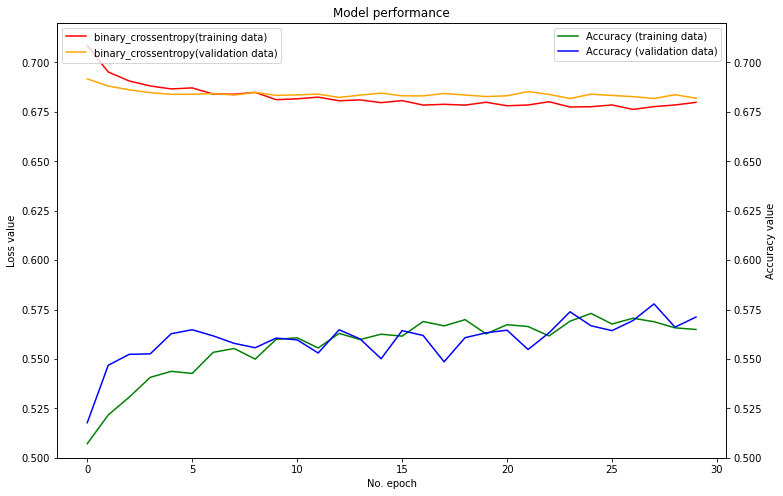

In [46]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

# Filters visualization

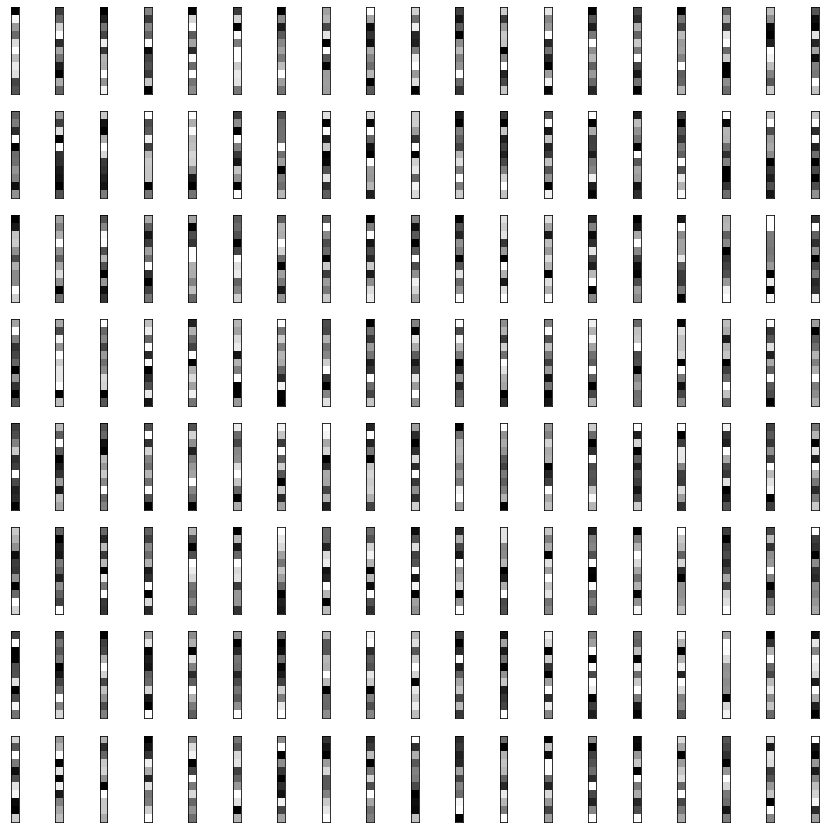

In [11]:
from matplotlib import pyplot

filters, biases = fitted_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 8, 1
pyplot.figure(figsize = (15,15))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(19):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 19, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature map visualization

In [12]:
filters = 8
outputs = [fitted_model.layers[0].output]
model = Model(inputs=fitted_model.inputs, outputs=outputs)

### Feature map for one example

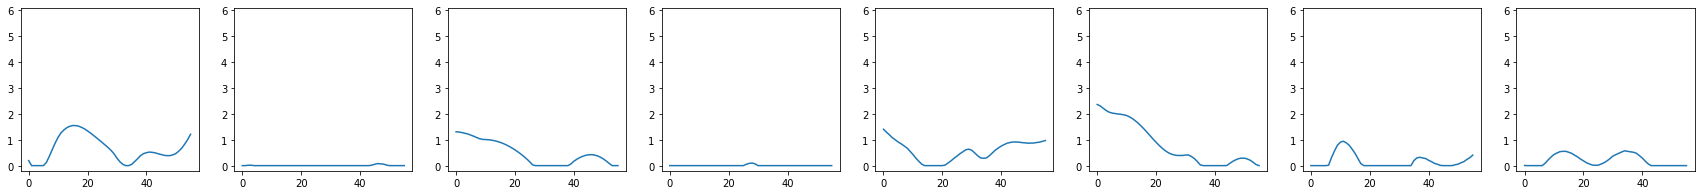

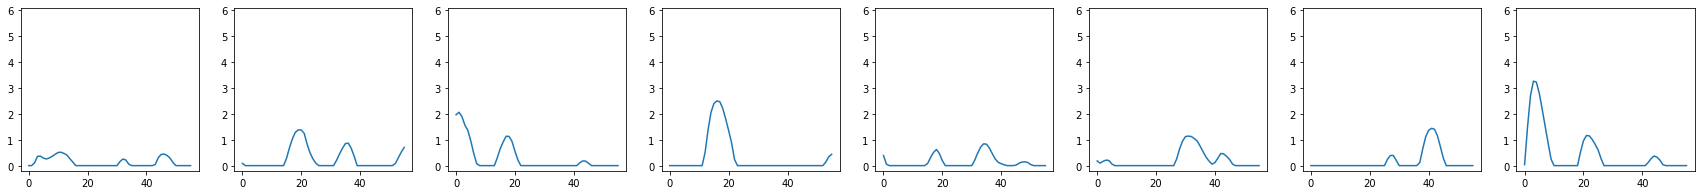

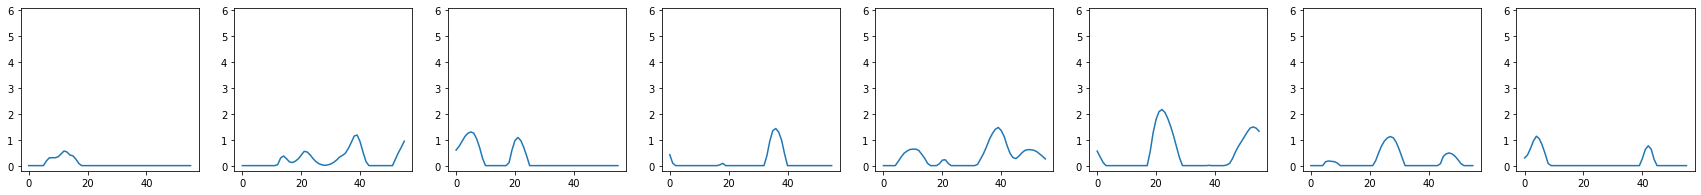

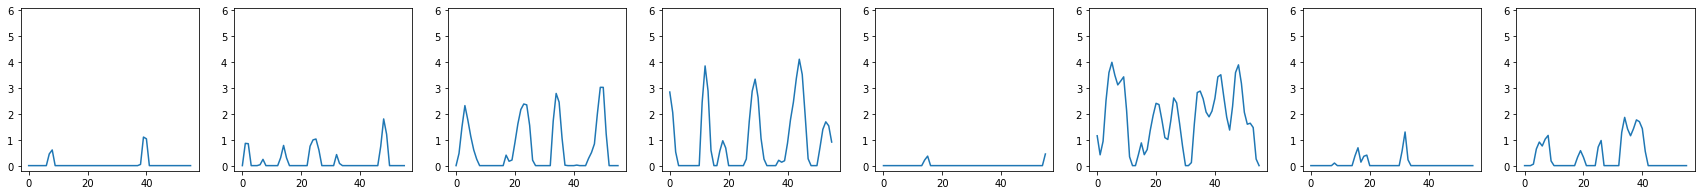

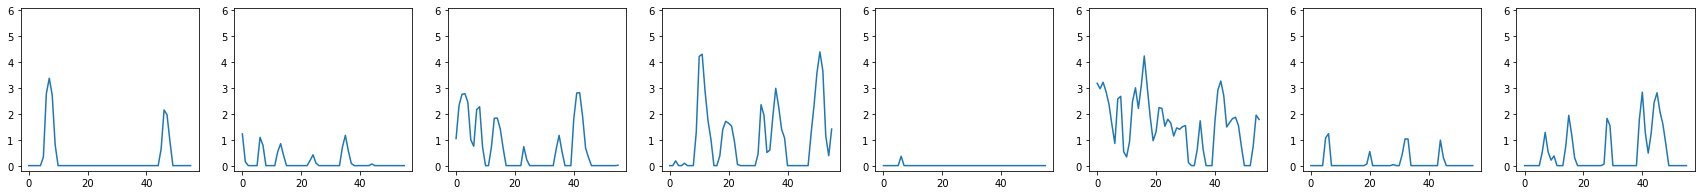

In [13]:
feature_maps = model.predict(np.expand_dims(X_validation[2],axis=0))

for i in range(5):
    pyplot.figure(figsize = (30,3))
    for x in range(filters):
        ax = pyplot.subplot(1, 8, x+1)
        pyplot.ylim(-0.2,6.1)
        pyplot.plot(feature_maps[0, :, i, x])
        ix += 1
    pyplot.show()#Podpisać osie - pasma, czas itp

# Mean maps

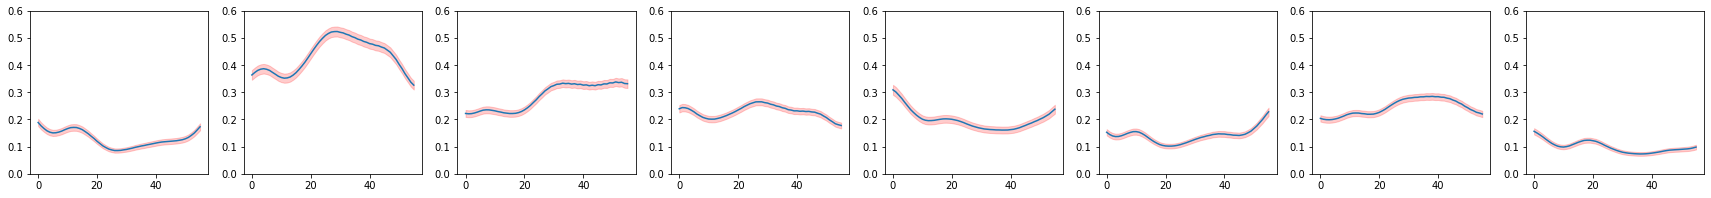

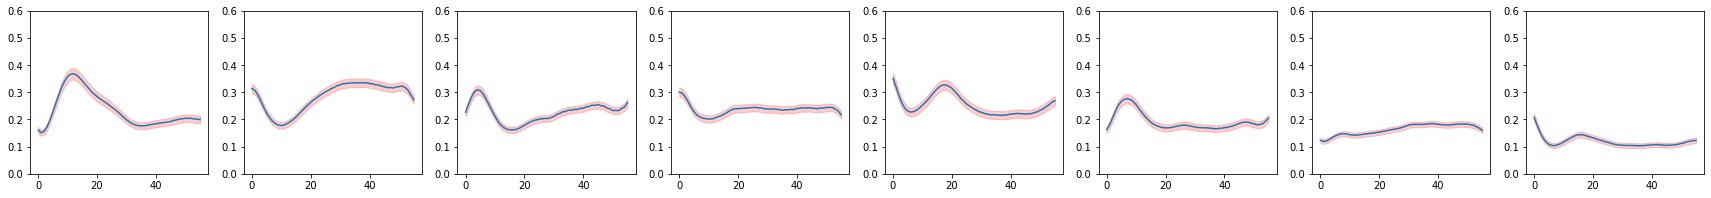

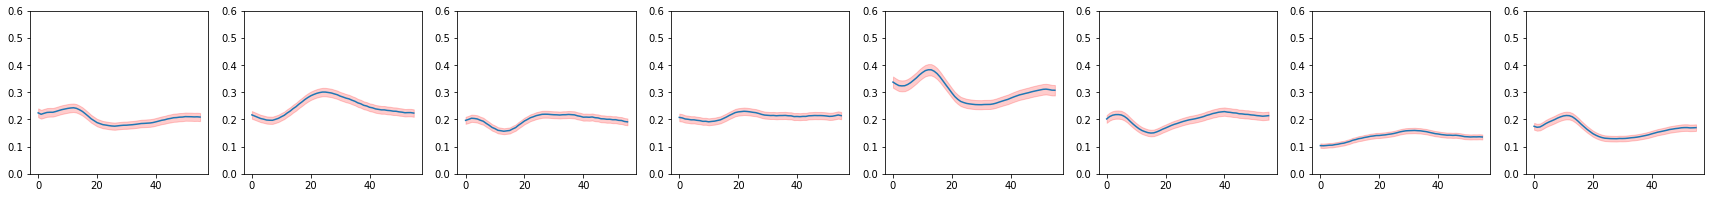

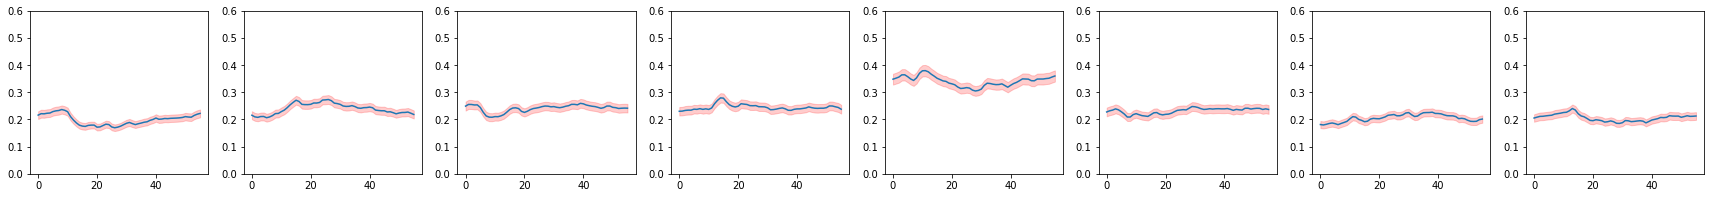

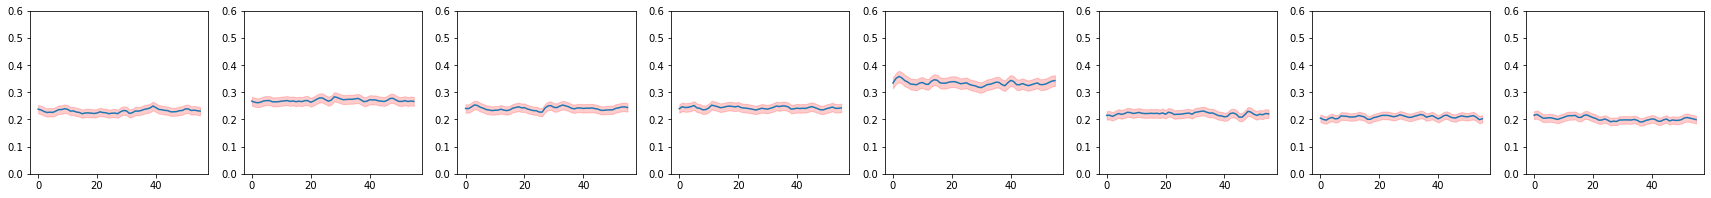

In [91]:
feature_maps = model.predict(X_validation)
plot_features(feature_maps, filters, (0,0.6))

## Dobrze sklasyfikowane

In [92]:
features_maps = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
features_good = features_maps[ind_good]

## Źle sklasyfikowane

In [93]:
features_maps = model.predict(X_validation)
ind_bad = np.where(fitted_model.predict_classes(X_validation) != class_no8)[0]
features_bad = features_maps[ind_bad]

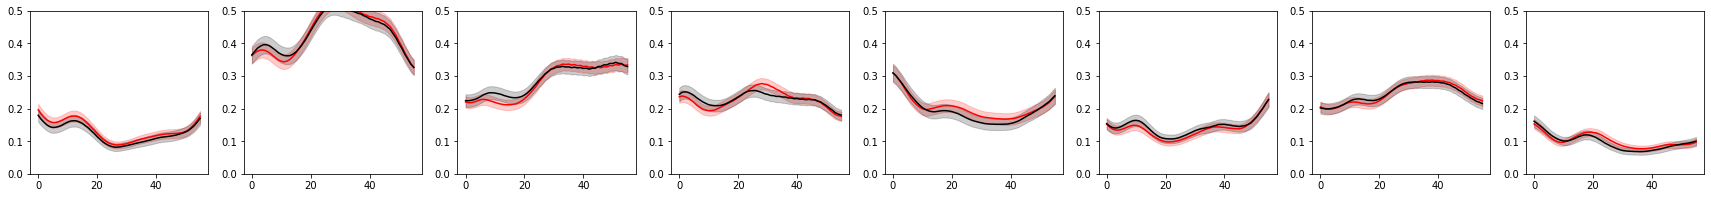

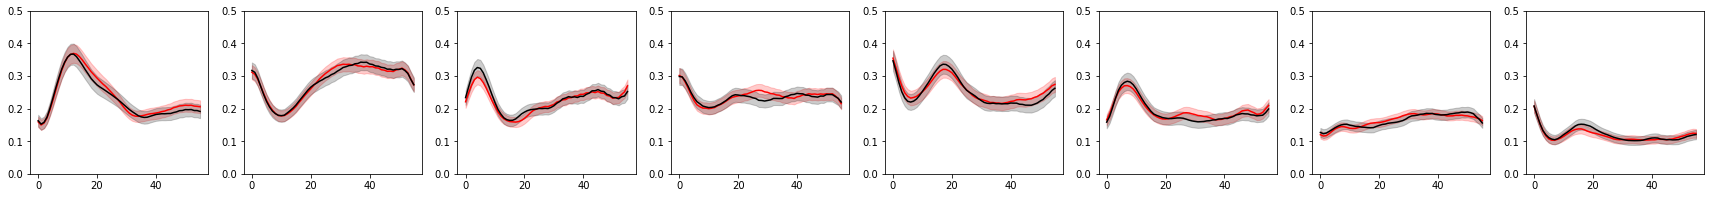

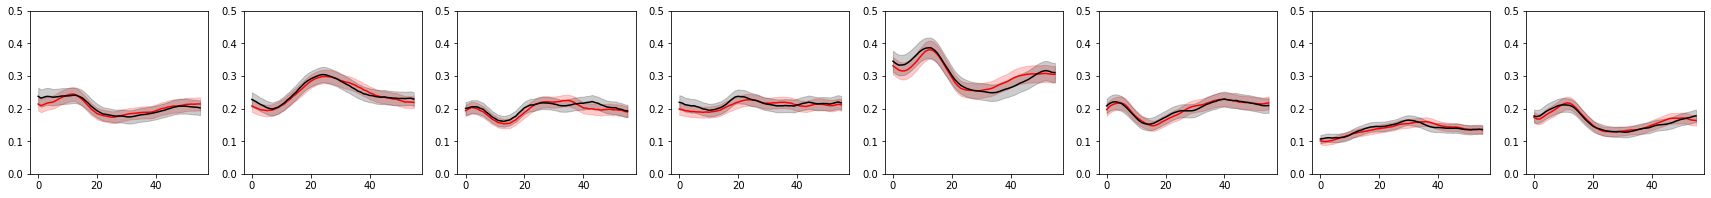

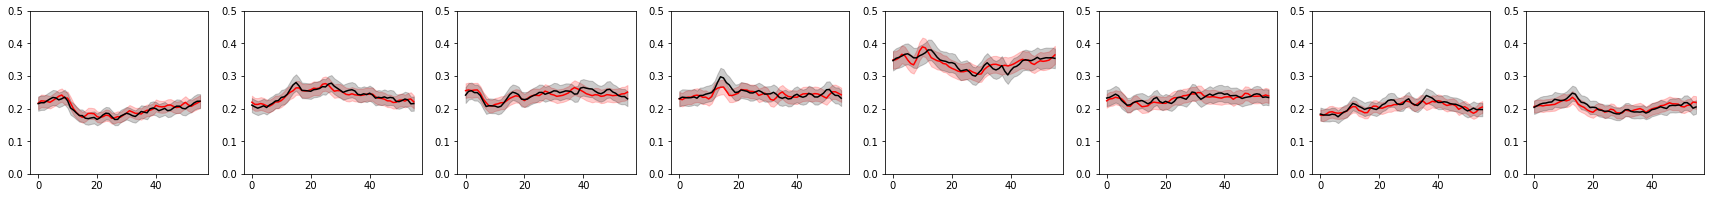

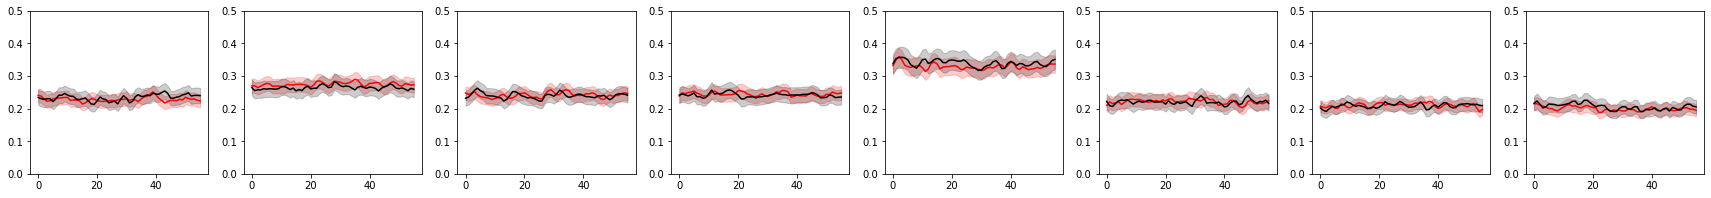

In [94]:
plot_compare_features(features_good, features_bad, filters, (0,0.5))

## Wśród poprawnie zaklasyfikowancyh kategoria 0

In [95]:
features = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
ind_good1 = np.where(class_no8 == 1)[0]
ind_good1 = np.unique(np.concatenate((ind_good, ind_good1)))
ind_good2 = np.where(class_no8 == 0)[0]
ind_good2 = np.unique(np.concatenate((ind_good, ind_good2)))

features_good = features[ind_good]
features_good1 = features[ind_good1]
features_good2 = features[ind_good2]

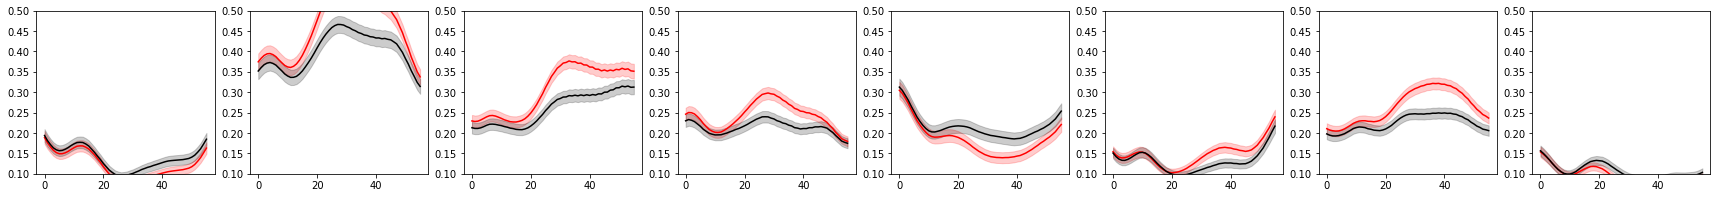

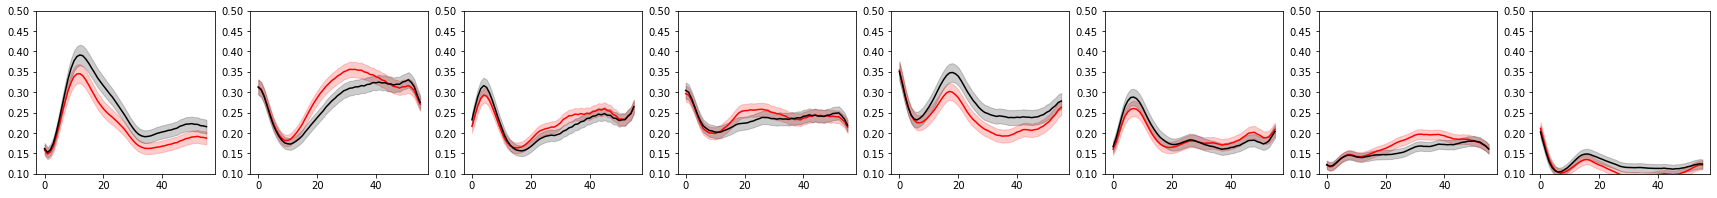

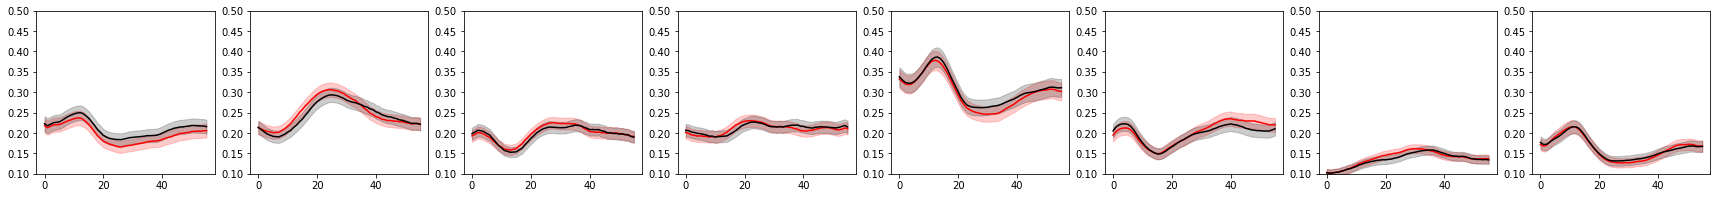

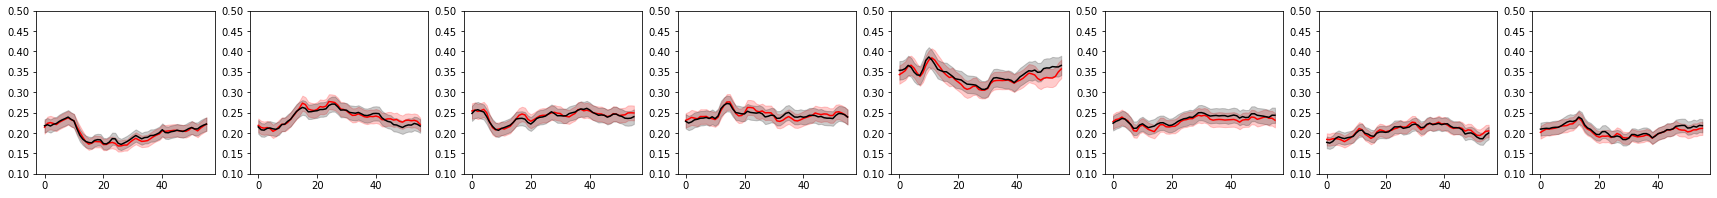

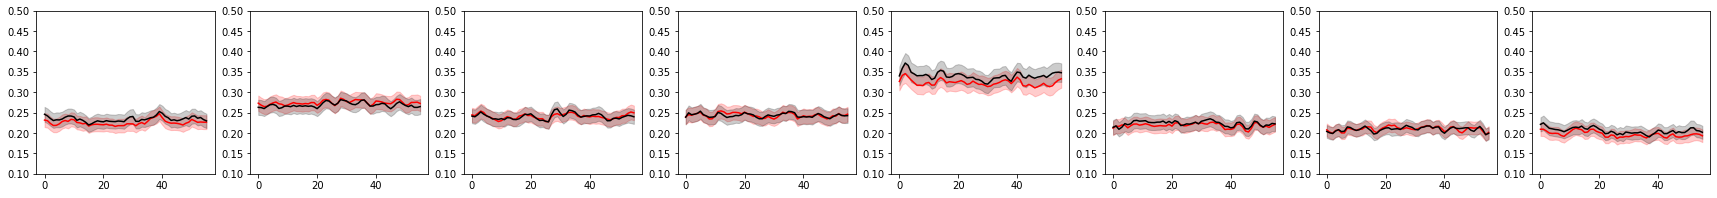

In [96]:
plot_compare_features(features_good1, features_good2, filters, ylim = (0.1,0.5))

In [97]:
#zasłanianie kolejnych fragmentów/pasm i sprw. walidacji (accuracy), można kanały zerować (najlepiej wartość stałą (średnia ze wszystkich?), nie nie brać)
#Macierz pasma x kanały - accuracy/zmianę accuracy (różnicę accuracy od "bazowego") - na raz wyłączam pasmo i dany kanał
#waliduje na sieci nauczonej całymi danymi
#5 sieci - zebrać taką macierz dla każdej i uśrednić (zapisać sobie dla obrazowania) pickle np.

## Collecting votes

In [98]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [99]:
X_validation = X_validation[:,5:71,:,:]
X_validation.shape

(7206, 66, 5, 19)

Test loss: 0.6823179682128931 / Test accuracy: 0.5577296614646912


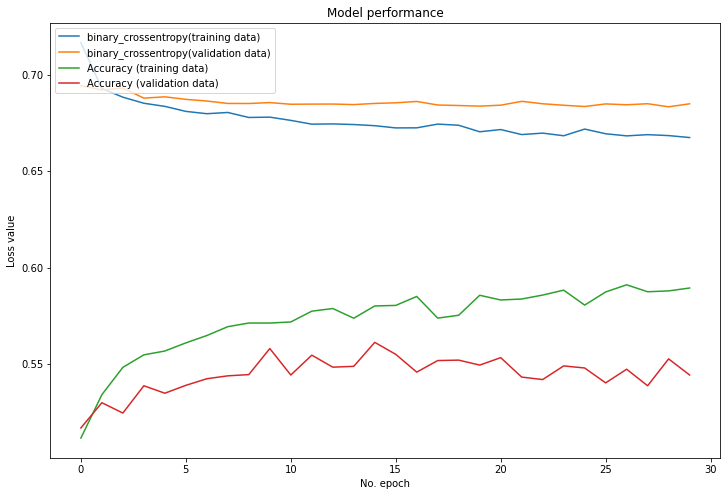

0
Test loss: 0.6824097191827548 / Test accuracy: 0.5618928670883179


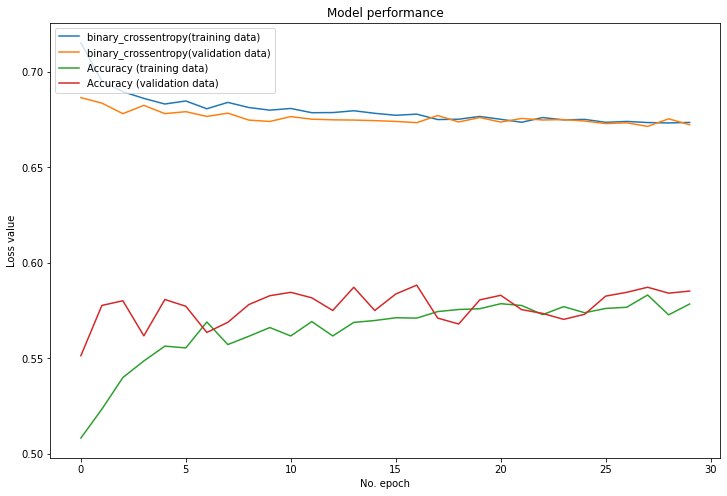

1
Test loss: 0.6833472742062955 / Test accuracy: 0.5537052750587463


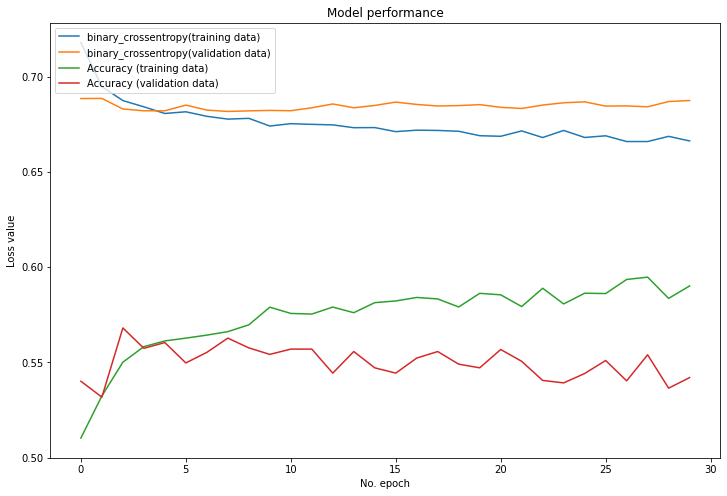

2
Test loss: 0.6814917866931569 / Test accuracy: 0.5642520189285278


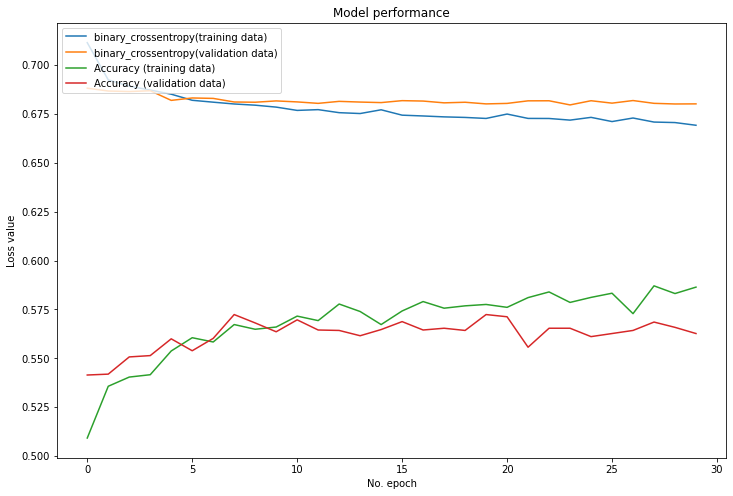

3
Test loss: 0.6798456850198782 / Test accuracy: 0.566888689994812


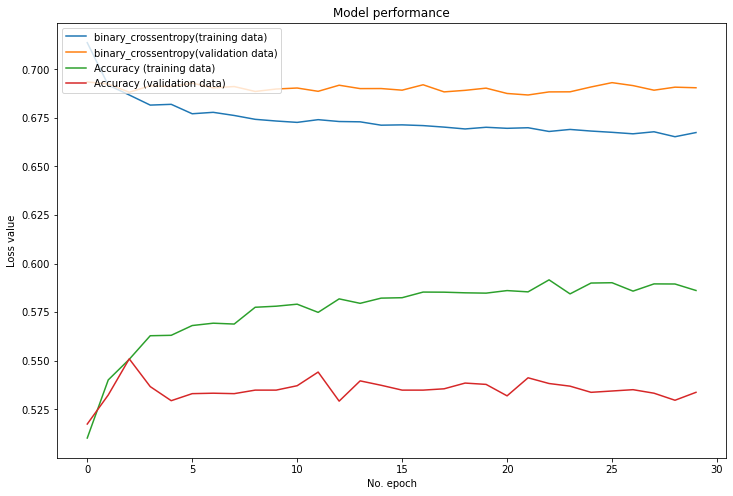

4
0.5682764363030808


In [101]:
batch_size = 200
no_epochs = 30

trials = y_validation.shape[0]
pred = np.zeros((5,trials))

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], option)
    X_test, y_test = get_test(X, y, combinations_test[i], option)
    X_train = X_train[:,5:71,:,:]
    X_test = X_test[:,5:71,:,:]
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    model = create_model(sample_shape, 2, (11,1),(11,1), 25, 50, optimizer='adam')
    
    fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs, verbosity = 0)
    fitted_model.save('./models/model31_'+str(i))
    "Getting validation and loss score"
    score = evaluate(fitted_model, X_validation, y_validation)

    "Plotting history"
    plot_history(hist, loss_fun)
    "Getting validation and loss score"
#     score = evaluate(fitted_model, X_validation, y_validation)
    pred[i] = fitted_model.predict_classes(X_validation)
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

In [102]:
replacement = np.mean(X_validation, axis = 0)
# prediction = np.empty((5,5,19,trials))
acc_score = np.empty((5,5,19))
for i in range(5):
    model = load_model('./models/model31_'+str(i))
    score = evaluate(model, X_validation, y_validation)
    acc = score[1]
    for band in range(5):
        for ch in range(19):
            X_temp = X_validation.copy()
            X_temp[:,:,band,ch] = replacement[:,band,ch]
            score = evaluate(model, X_temp, y_validation, verbose = 0)
            acc_score[i,band,ch] = acc-score[1]
#             prediction[i,band,ch,:] = model.predict_classes(X_temp)
        print(f'FINISHED BAND: {band}')
    print('FINISHED MODEL ' + str(i))

Test loss: 0.6823179682128931 / Test accuracy: 0.5577296614646912
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 0
Test loss: 0.6824097191827548 / Test accuracy: 0.5618928670883179
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 1
Test loss: 0.6833472742062955 / Test accuracy: 0.5537052750587463
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 2
Test loss: 0.6814917866931569 / Test accuracy: 0.5642520189285278
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 3
Test loss: 0.6798456850198782 / Test accuracy: 0.566888689994812
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 4


In [103]:
# np.save('predictions.npy',prediction)
np.save('acc_score31.npy',acc_score)
import matplotlib.colors as mc

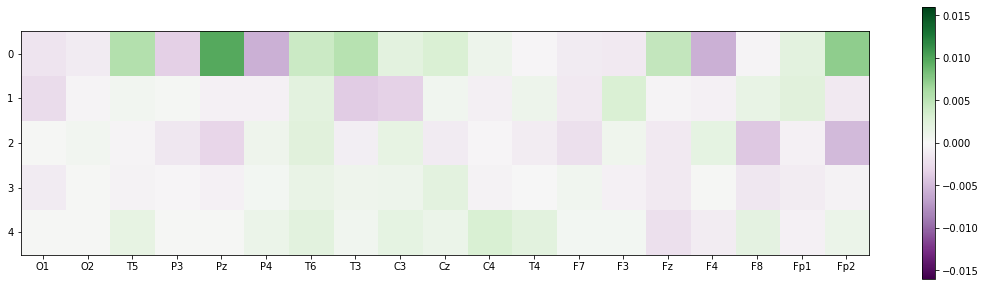

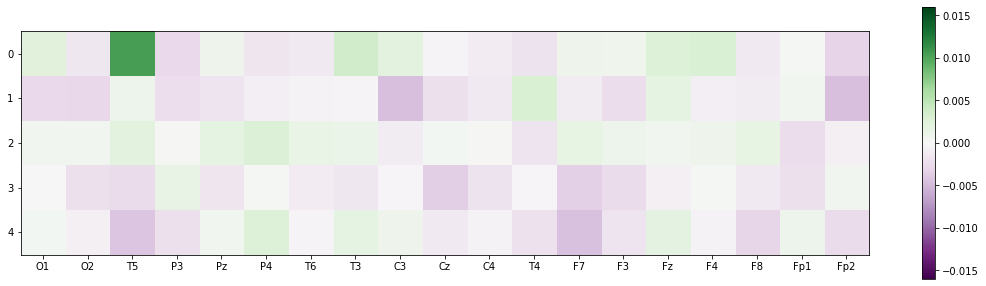

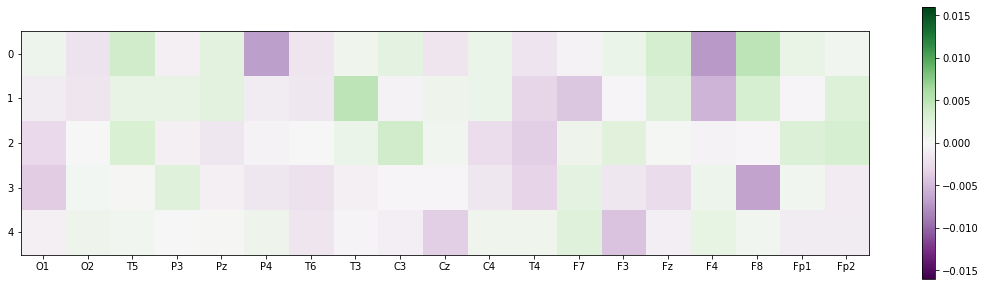

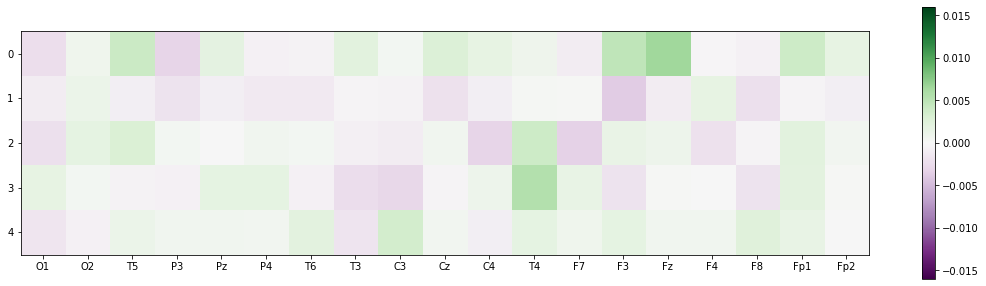

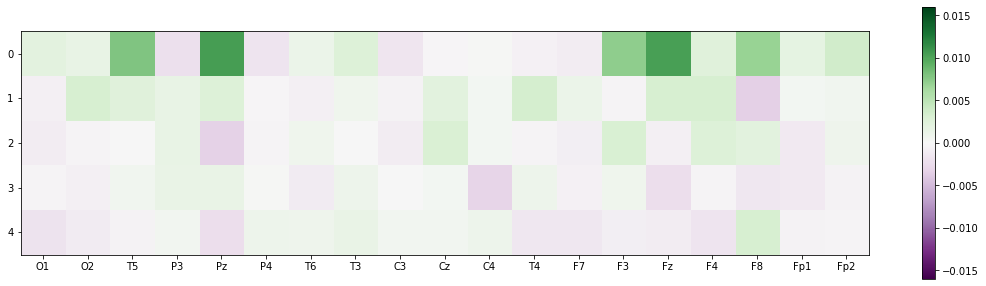

In [107]:
acc_score = np.load('acc_score31.npy')
# fig, ax1 = plt.subplots(1,1)

# ax1.imshow(data, cmap='jet', interpolation='nearest')

# ax1.set_xticklabels(['', 0,10,20,30,40])
chan = np.load('channels.npy')
for i in range(5):
    plt.figure(figsize = (19,5))
    
    plt.imshow(acc_score[i], cmap = 'PRGn')
    plt.clim(-0.016,0.016)
    plt.xticks(np.arange(len(chan)), labels=chan)
    plt.colorbar()
    plt.show()

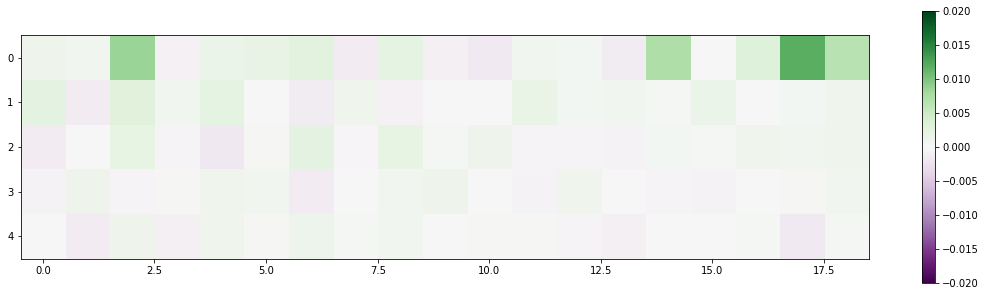

In [105]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0), cmap = 'PRGn')
plt.clim(-0.02,0.02)
plt.colorbar()
plt.show()
#podpisać nazwami kanałów

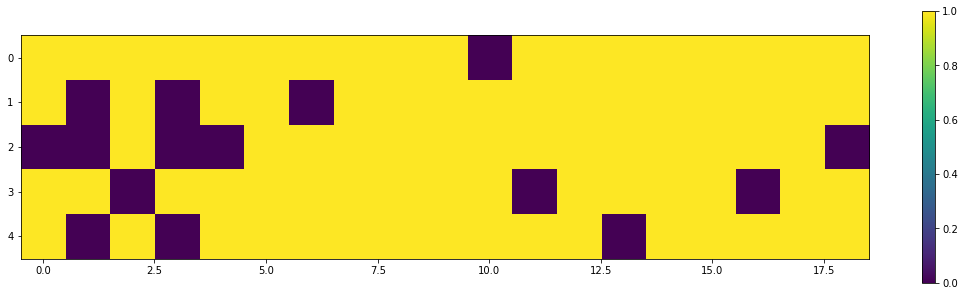

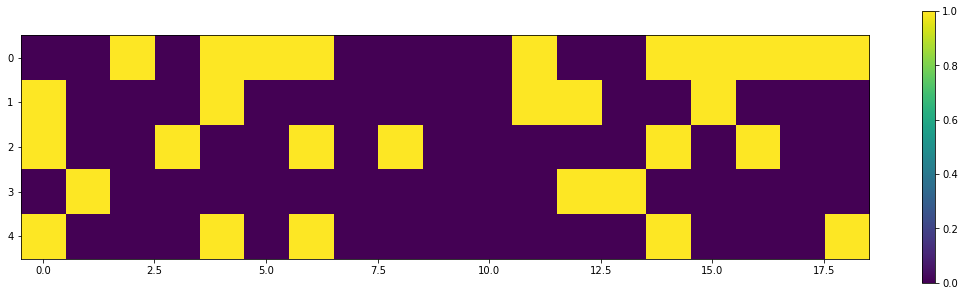

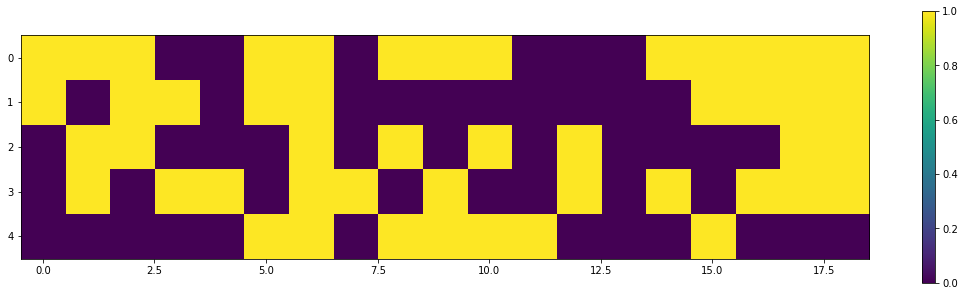

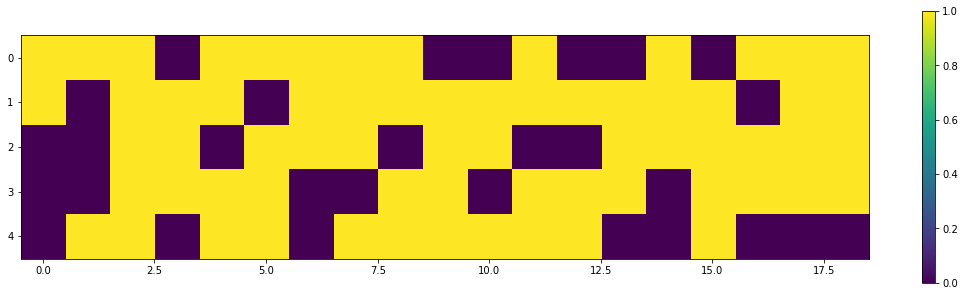

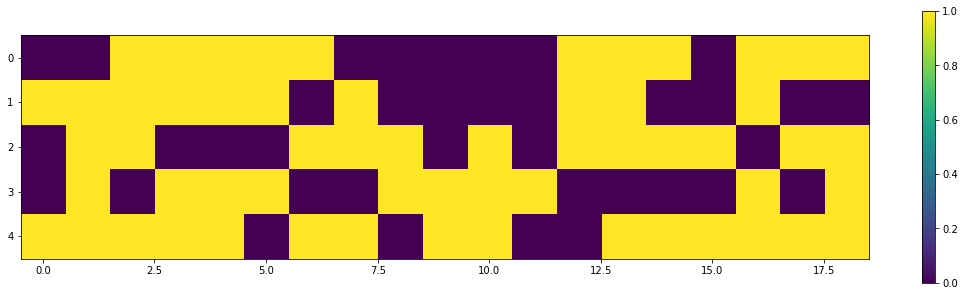

In [106]:
test = acc_score.copy()
test[test>=0] = 1
test[test<0] = 0
for i in range(5):
    plt.figure(figsize = (19,5))
    plt.imshow(test[i])
#     plt.clim(-0.005,0.02)
    plt.colorbar()
    plt.show()

In [33]:
test2 = np.sum(test, axis=0)
test2[test2<3] = 0
test2[test2>=3] = 1

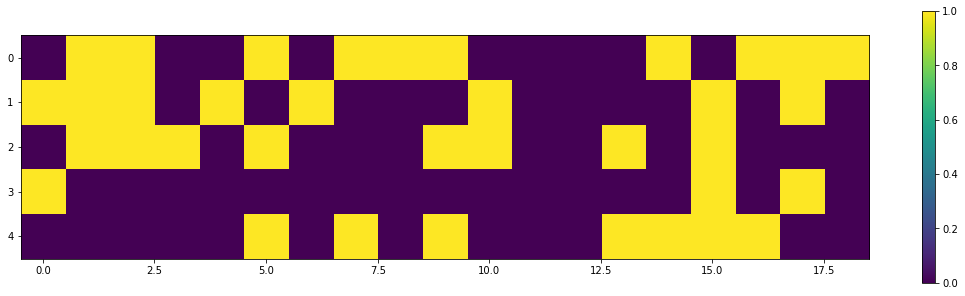

In [34]:
plt.figure(figsize = (19,5))
plt.imshow(test2)
plt.colorbar()
plt.show()

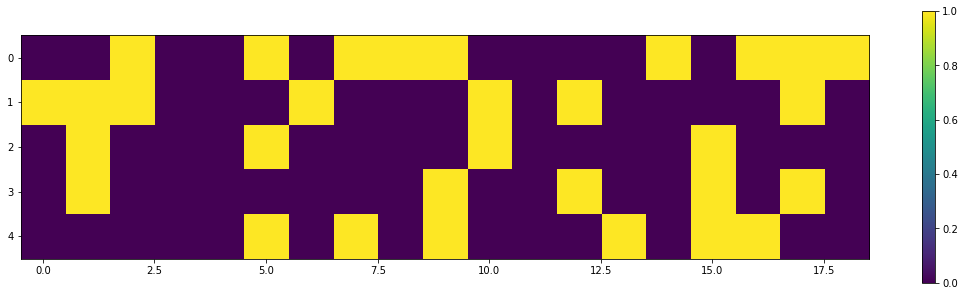

In [35]:
AAA = np.mean(acc_score, axis=0)
AAA[AAA>=0] = 1
AAA[AAA<0] = 0

plt.figure(figsize = (19,5))
plt.imshow(AAA)
# plt.clim(-0.005,0.02)
plt.colorbar()
plt.show()

In [37]:
chan = np.load('channels.npy')

In [40]:
chan[14]

'Fz'

# OKLUZJA

In [113]:
replacement = ( np.mean(X_train, axis = 0) + np.mean(X_test, axis = 0) ) / 2

In [115]:
acc_score = np.empty((5,19))

In [87]:
batch_size = 200
no_epochs = 10

trials = y_validation.shape[0]
pred = np.zeros((5,19,trials))

for band in range(5):
    for ch in range(19):
        X_train, y_train = get_training(X, y, combinations_train[0], option)
        X_test, y_test = get_test(X, y, combinations_test[0], option)
        sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
        X_train[:,:,band,ch] = replacement[:,band,ch]
        X_test[:,:,band,ch] = replacement[:,band,ch]
        model = create_model(sample_shape, 2, (7,1),(7,1), 20, 40)

        fitted_model, _ = fit(model, X_train, y_train, X_test, y_test, 
                                batch_size, no_epochs, verbosity = 0)
        fitted_model.save(.s/model0_B'+str(band)+'CH'+str(ch))

        "Getting validation and loss score"
        score = evaluate(fitted_model, X_validation, y_validation)
        acc_score[band,ch] = score[1]
        pred[band,ch,:] = fitted_model.predict_classes(X_validation)

(77,)